In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib. pyplot as plt
import mne
import numpy as np
from no_wander.process import get_files_by_session, load_session_data
from pathlib import Path

mne.set_log_level('WARNING')

%matplotlib inline

In [4]:
DATA_DIR = Path.cwd().parent / 'data' / 'processed'
FILE_GLOB = "*.EEG.*.csv"
SAMPLE_SIZE_SEC = 7

In [5]:
session_files = get_files_by_session(DATA_DIR, FILE_GLOB)

In [6]:
raws = []
mne_info = None
for files in list(session_files.values())[:500]:
    _, data = load_session_data(files, aux_channel=None, rename=False)
    if mne_info is None:
        mne_info = mne.create_info(
            ch_names=[col.replace('EEG_', '') for col in data.columns],
            ch_types=['eeg'] * (len(data.columns) - 1) + ['stim'],
            sfreq=256,
        )
    data = data.values.T
    data[:-1, :] *= 1e-6
    data[-1, data[-1, :] != 1] = 0
    
    raw = mne.io.RawArray(data=data, info=mne_info)
    raw.set_eeg_reference(projection=True).apply_proj()
    raw.filter(l_freq=1, h_freq=45, picks=['eeg'], method='iir')
    raw.set_montage("standard_1005")
    raws.append(raw)
    
    del data

raw = mne.concatenate_raws(raws)

In [7]:
def get_epochs(raw, events, tmin=0, tmax=0):
    event_id = dict(recovery=1)
    epochs = mne.Epochs(
        raw,
        events,
        baseline=None,
        event_id=event_id,
        picks=mne.pick_types(raw.info, eeg=True, exclude='bads'),
        reject=dict(eeg=100e-6),
        tmax=tmax,
        tmin=tmin,
    )
    epochs.drop_bad()
    print(epochs)
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
    return epochs

events = mne.find_events(raw)
epochs_pre = get_epochs(raw, events, tmin=-SAMPLE_SIZE_SEC)
epochs_post = get_epochs(raw, events, tmax=SAMPLE_SIZE_SEC)

<Epochs  |   742 events (all good), -7 - 0 sec, baseline off, ~19 kB, data not loaded,
 'recovery': 742>
sample drop %:  4.381443298969067
<Epochs  |   736 events (all good), 0 - 7 sec, baseline off, ~19 kB, data not loaded,
 'recovery': 736>
sample drop %:  5.154639175257736


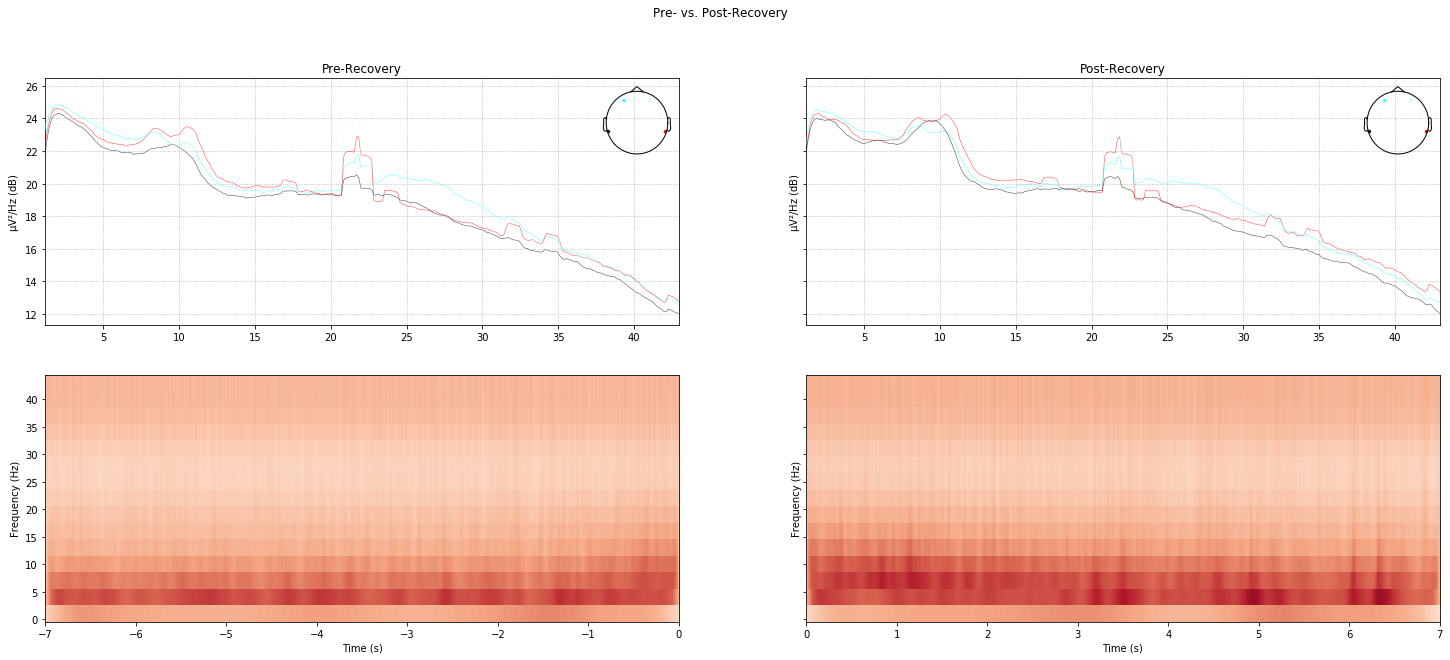

In [9]:
figsize = [25, 10]
plt.rcParams['figure.figsize'] = figsize
freqs = np.arange(1, 45, 3)

fig, axes = plt.subplots(nrows=2, ncols=2, sharey='row')
ax_pre, ax_post = axes.T
for epoch_type, epochs, ax in [('Pre', epochs_pre, ax_pre), ('Post', epochs_post, ax_post)]:
    epochs.plot_psd(freqs[0], freqs[-1], spatial_colors=True, average=False, ax=ax[0], show=False)
    ax[0].set_title(f"{epoch_type}-Recovery")
    mne.time_frequency.tfr_morlet(epochs, n_cycles=2, return_itc=False, freqs=freqs, decim=3).plot(axes=ax[1], show=False, colorbar=False)
fig.suptitle("Pre- vs. Post-Recovery")
fig.show()

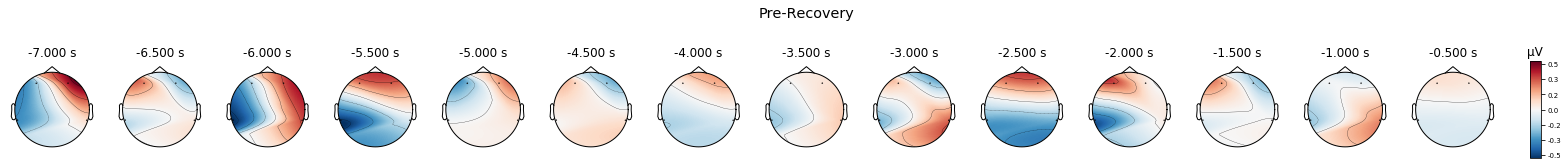

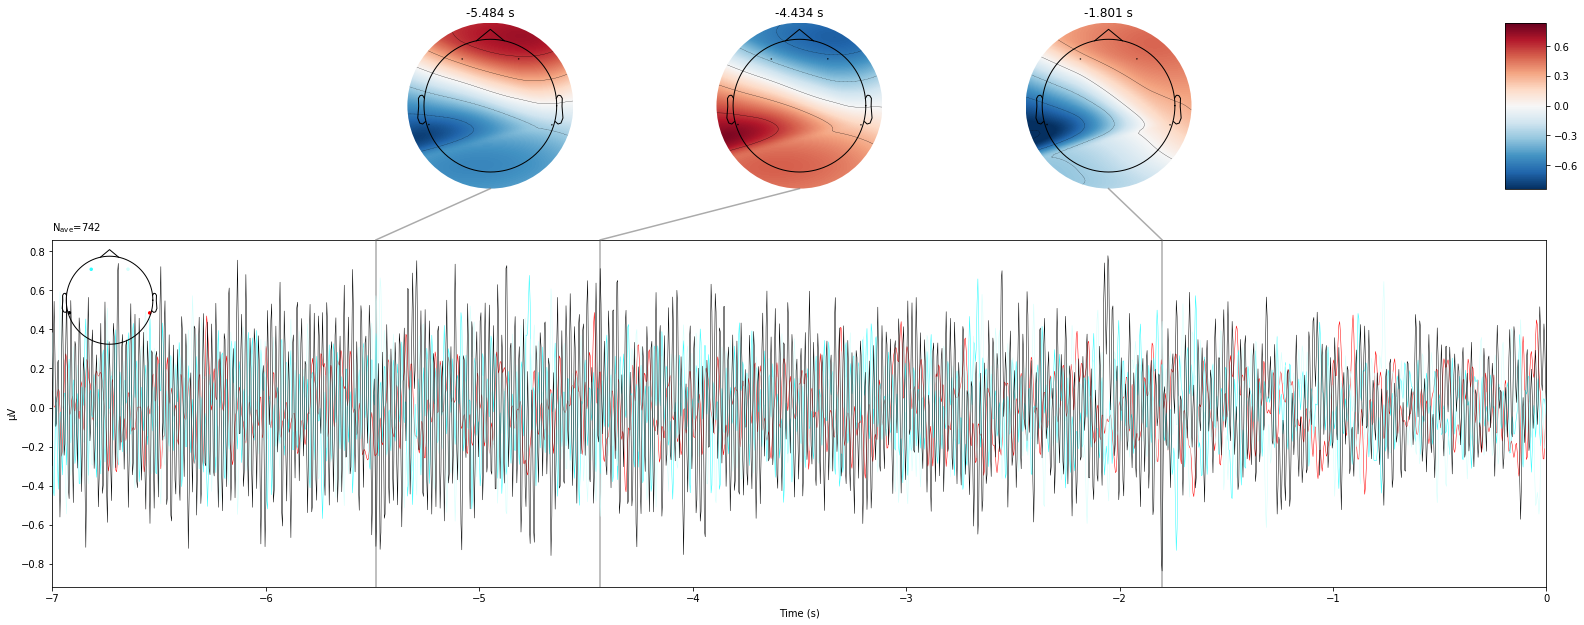

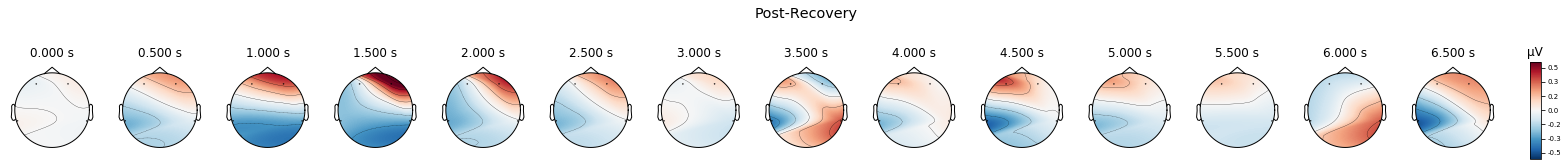

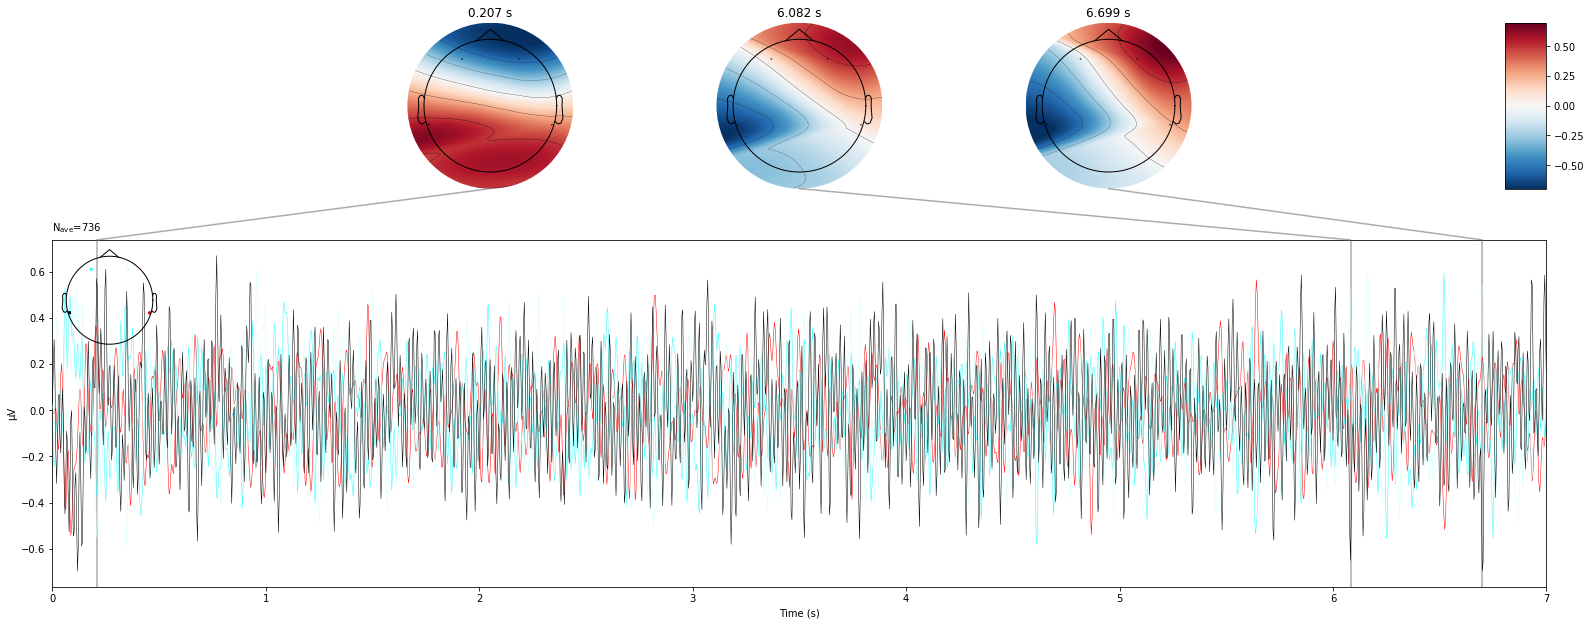

In [10]:
for epoch_type, epochs in [('Pre', epochs_pre), ('Post', epochs_post)]:
    times = np.arange(*epochs.times[[0, -1]].astype(int), 0.5)
    evoked = epochs.average()

    evoked.plot_topomap(title=f"{epoch_type}-Recovery", times=times)
    fig = evoked.plot_joint(title=None, show=False)
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    fig.show()

* Bands over time
* Wavelet transform unsupervised
* ICA/SSP then dipole
* PCA
* N2pc ERP

# Performance Baseline: Simple Models
Attempt SVM for baseline